In [2]:
import numpy as np
import matplotlib.pyplot as plt

MAX_HEIGHT = 75         # [mm]
PROFILE_WIDTH = 200     # [mm]
wheel_base = 1200       # [mm]
L = 3600                # [mm]
M = 200                 # [kg]
g = 9.81                # [m/s^2]
F_point = M * g / 4.0   # [N] (per wheel)

a = (L - wheel_base) / 2.0 # [mm] distance frome edge to point load (wheel)

### Calculate Peak Moment

In [3]:
M_max = F_point * a / 2.0
print(M_max)

294300.0


### Calculate Bending Stiffness

In [4]:
h = MAX_HEIGHT  # [mm]
t = 0.5         # [mm]
E = 70e9        # [N/mm^2] (Alu)
Iy = (1.0/12.0) * (PROFILE_WIDTH * h**3 - (PROFILE_WIDTH-2*t) * (h-2*t)**3)
BendingStiffness = E * Iy

print(BendingStiffness)

2.1789973333333332e+16


### Calculate Deformation in Wheel Contact Point

In [5]:
def w(x, F, L, a, b, EI):
    if x <= a:
        return F*b*x / (6*EI*L) * (L**2 - b**2 - x**2)
    else:
        return F*a*(L-x) / (6*EI*L) * (2*L*x - a**2 - x**2)

# Find total deformation in pos a for both point loads
w1 = w(x=a, F=F_point, L=L, a=a, b=(L-a), EI=BendingStiffness)
w2 = w(x=a, F=F_point, L=L, a=(L-a), b=a, EI=BendingStiffness)
w_tot_a = w1 + w2
print(w1)

1.728795140027707e-05


### Calculate Mass

In [6]:
rho = 0.0027 # g/mm^3
mass = (PROFILE_WIDTH * h - (PROFILE_WIDTH-2*t) * (h-2*t)) * L * rho
print(mass)

2663.28


### Calculate deformations

3.727714520684743e-05
2400.0


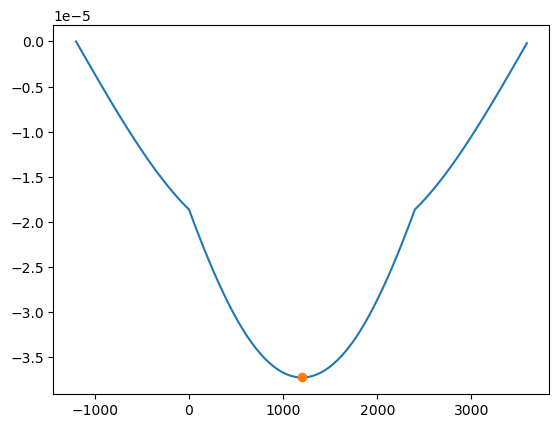

In [7]:
F1 = F_point
F2 = F_point

w01 = F1*L**3/(48*BendingStiffness) # nedbøyningskoeffisient for F1 (bakre hjulpar)
w02 = F2*L**3/(48*BendingStiffness) # nedbøyningskoeffisient for F2 (fremre hjulpar)

step_size = 10.0

x = np.arange(0.0,L + wheel_base, step_size)
antall_punkter = len(x)

x_rear = x-wheel_base

w = np.zeros(len(x))

for i in range(antall_punkter):
    if x[i] <= wheel_base:
        w[i] = w01*(4.0*(x[i]/L)**3.0 - 3.0*x[i]/L) 
    elif x[i] <= L/2.0:
        w[i] = w01*(4.0*(x[i]/L)**3.0 - 3.0*x[i]/L) + w02*(4.0*(x_rear[i]/L)**3.0 - 3.0*x_rear[i]/L)     
    elif x[i] <= L/2.0 + wheel_base:
        w[i] = w01*(4.0*((L-x[i])/L)**3.0 - 3.0*(L-x[i])/L) + w02*(4.0*(x_rear[i]/L)**3.0 - 3.0*x_rear[i]/L)    
    elif x[i] <= L:
        w[i] = w01*(4.0*((L-x[i])/L)**3.0 - 3.0*(L-x[i])/L) + w02*(4.0*((L-x_rear[i])/L)**3.0 - 3.0*(L-x_rear[i])/L) 
    else:
        w[i] = w02*(4.0*((L-x_rear[i])/L)**3.0 - 3.0*(L-x_rear[i])/L) 
        
w_abs = np.abs(w)
w_max = np.max(w_abs)
index_ved_w_max = np.argmax(w_abs)
x_ved_w_max = x[index_ved_w_max]

print(w_max)
print(x_ved_w_max)

plt.plot(x-wheel_base,w)
plt.plot(x_ved_w_max-wheel_base,-w_max, 'o')
plt.show()  


### Shell element Mid plane offset deviations

In [36]:
t = 3
max_spars = 8

I_approx_list = np.zeros(max_spars+1)
I_analytical_list = np.zeros(max_spars+1)

# Calculate box profile 
I_horizontal_approx = (1.0/12.0) * (PROFILE_WIDTH - t) * t**3 + ((h - t)/2.0)**2 * (PROFILE_WIDTH - t) * t # Steiners sats bunn eller topp
I_vertical_approx = (1.0/12.0) * (t) * (h - t)**3 # Steiners sats høyre eller venstre side
I_box_approx = 2 * I_horizontal_approx + 2 * I_vertical_approx
I_approx_list[0] = I_box_approx

# Calculate analytical
I_box_analytical = (1.0/12.0) * (PROFILE_WIDTH * h**3 - (PROFILE_WIDTH-2*t) * (h-2*t)**3)
I_analytical_list[0] = I_box_analytical
I_spar_analytical = (1.0/12.0) * t * (h-2*t)**3

# add spars
for i in range(max_spars):
    # add spar contribution to I and append to list
    I_box_approx += I_vertical_approx
    I_approx_list[i+1] = I_box_approx

    I_box_analytical += I_spar_analytical
    I_analytical_list[i+1] = I_box_analytical


print(np.round(I_approx_list/I_analytical_list * 100, 2))

[ 99.94 100.57 101.14 101.66 102.14 102.58 102.99 103.37 103.72]
